<a href="https://colab.research.google.com/github/AdnanSakal/Machine_Translation/blob/main/machine_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import zipfile
import os

In [ ]:
!pip install tensorflow-text

In [ ]:
import tensorflow_text as tf_text

In [ ]:
!wget 'http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip'

In [ ]:
zip_ref = zipfile.ZipFile("spa-eng.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
with open("/content/spa-eng/spa.txt","r") as f:
  text = f.read()

In [ ]:
text

In [ ]:
context = np.array([i.split("\t")[0] for i in text.splitlines()])

In [ ]:
target = np.array([i.split("\t")[1] for i in text.splitlines()])

In [ ]:
context[500],target[500]

('Have some.', 'Tome alguno.')

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(context,target,test_size=0.2,random_state = 42)

In [ ]:
x_train[0],y_train[0]

('I have no choice at all.', 'No tengo otra opción en absoluto.')

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train)).batch(64).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((x_test,y_test)).batch(64).prefetch(tf.data.AUTOTUNE)

In [ ]:
test_dataset

In [ ]:
def preprocess(text):
  text = tf_text.normalize_utf8(text,"NFKD")
  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text,"[^a-z.,!?¿]"," ")
  text = tf.strings.regex_replace(text,"[.,!?¿]",r" \0 ")
  text = tf.strings.strip(text)
  text = tf.strings.join(["[START]",text,"[END]"],separator=" ")
  return text

In [ ]:
len(context)

118964

(array([1.2456e+04, 3.8517e+04, 3.6392e+04, 2.3757e+04, 4.8780e+03,
        1.8250e+03, 8.2200e+02, 1.5100e+02, 7.8000e+01, 4.1000e+01,
        2.9000e+01, 2.0000e+00, 2.0000e+00, 8.0000e+00, 4.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([ 1. ,  3.3,  5.6,  7.9, 10.2, 12.5, 14.8, 17.1, 19.4, 21.7, 24. ,
        26.3, 28.6, 30.9, 33.2, 35.5, 37.8, 40.1, 42.4, 44.7, 47. ]),
 <BarContainer object of 20 artists>)

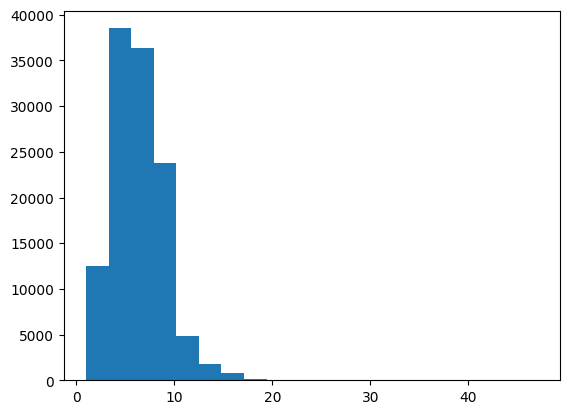

In [ ]:
len_of_word = [len(i.split()) for i in context]
plt.hist(len_of_word,bins = 20)

In [ ]:
np.percentile(len_of_word,98)

13.0

In [ ]:
from tensorflow.keras.layers import TextVectorization
context_vect_layer = TextVectorization(max_tokens = 5000,
                                    standardize = preprocess,
                                    output_sequence_length = 16
                                    )

In [ ]:
context_vect_layer.adapt(train_dataset.map(lambda x,y:x))

(array([5.6858e+04, 5.4272e+04, 6.9600e+03, 7.2000e+02, 1.0800e+02,
        2.7000e+01, 1.1000e+01, 5.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([ 1. ,  5.8, 10.6, 15.4, 20.2, 25. , 29.8, 34.6, 39.4, 44.2, 49. ]),
 <BarContainer object of 10 artists>)

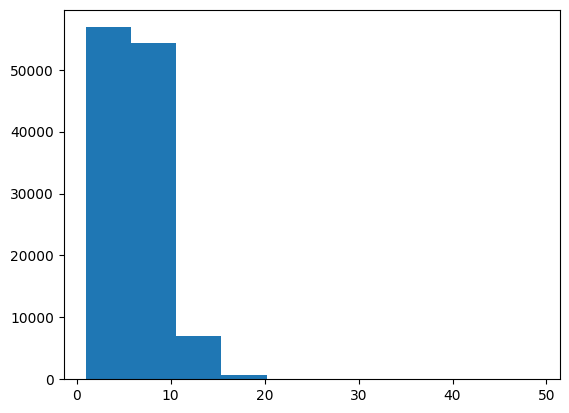

In [ ]:
len_of_word_ = [len(i.split()) for i in target]
plt.hist(len_of_word_)

In [ ]:
np.percentile(len_of_word_,98)

13.0

In [ ]:
target_vect_layer = TextVectorization(max_tokens = 5000,
                                      standardize = preprocess,
                                      output_sequence_length = 16
                                      )

In [ ]:
target_vect_layer.adapt(train_dataset.map(lambda x,y:y))

In [ ]:
def another_preprocess(context,target):
  context = context_vect_layer(context)
  target = target_vect_layer(target)
  target_in = target[:,:-1]
  target_out = target[:,1:]
  return (context,target_in),target_out

In [ ]:
new_train_dataset = train_dataset.map(another_preprocess)
new_test_dataset = test_dataset.map(another_preprocess)

In [ ]:
for (i,ii),j in new_train_dataset.take(1):
  print(i[0])
  eg_con = i
  print(ii[0])
  eg_target_in = ii
  print(j[0])
  eg_target_out = j

tf.Tensor([  3   5  22  75 758  43  59   2   4   0   0   0   0], shape=(13,), dtype=int64)
tf.Tensor([   3    8   51  183 1473   16   12 1617    2    4    0    0], shape=(12,), dtype=int64)
tf.Tensor([   8   51  183 1473   16   12 1617    2    4    0    0    0], shape=(12,), dtype=int64)


In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self):
    super().__init__()
    self.embedding = tf.keras.layers.Embedding(input_dim = 5000,
                                               output_dim = 256
                                               )
    self.lstm = tf.keras.layers.LSTM(512,return_sequences = True)

  def call(self,input):
    x = self.embedding(input)
    x = self.lstm(x)
    return x

In [ ]:
encoder = Encoder()
eg_context = encoder(eg_con)
eg_context

<tf.Tensor: shape=(64, 13, 512), dtype=float32, numpy=
array([[[ 1.4196661e-04,  1.4751196e-03, -4.9320706e-03, ...,
         -5.0907112e-03, -8.0890823e-03, -4.8283250e-03],
        [ 6.1583309e-04, -3.2233943e-03, -3.1223753e-03, ...,
         -3.4603635e-03, -8.2590478e-03, -6.0584494e-03],
        [ 2.4971499e-03, -5.8839684e-03, -2.0031298e-03, ...,
         -1.7244548e-04, -1.0488007e-02, -7.5098146e-03],
        ...,
        [ 2.9142525e-03, -7.7094068e-03,  1.0172575e-03, ...,
         -7.2001019e-03,  1.9877763e-03,  5.4998174e-03],
        [ 5.0805961e-03, -6.9593019e-03,  7.4281410e-04, ...,
         -9.1714021e-03,  3.6878786e-03,  5.1454599e-03],
        [ 6.7556887e-03, -6.0962178e-03,  6.9956650e-04, ...,
         -1.0833677e-02,  4.5617782e-03,  4.7136787e-03]],

       [[ 1.4196661e-04,  1.4751196e-03, -4.9320706e-03, ...,
         -5.0907112e-03, -8.0890823e-03, -4.8283250e-03],
        [ 6.1583309e-04, -3.2233943e-03, -3.1223753e-03, ...,
         -3.4603635e-03, -8.

In [ ]:
class Attention(tf.keras.layers.Layer):
  def __init__(self):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(num_heads = 1,key_dim = 256)
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()
  def call(self,input,eg_context):
    x = self.mha(input,eg_context)
    x = self.add([input,x])
    x = self.layer_norm(x)
    return x

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self):
    super().__init__()
    self.word_to_index = tf.keras.layers.StringLookup(vocabulary = target_vect_layer.get_vocabulary(),
                                                      mask_token = "",
                                                      oov_token = "[UNK]"

                                                      )
    self.index_to_word = tf.keras.layers.StringLookup(vocabulary = target_vect_layer.get_vocabulary(),
                                                      mask_token = "",
                                                      oov_token = "[UNK]",
                                                      invert = True
                                                      )
    self.start_token = self.word_to_index("[START]")
    self.end_token = self.word_to_index("[END]")
    self.embedding = tf.keras.layers.Embedding(input_dim = 5000,
                                               output_dim = 256
                                               )
    self.attention = Attention()
    self.lstm = tf.keras.layers.LSTM(512,return_sequences=True,return_state = True)
    self.dense = tf.keras.layers.Dense(5000)

  def call(self,input,encoder_context,return_state = False,state = None):
    x = self.embedding(input)
    x,state_c,state_h = self.lstm(x,initial_state = state)
    x = self.attention(x,encoder_context)
    x = self.dense(x)
    if return_state:
      return x,[state_c,state_h]
    else:
      return x

  def get_initial_state(self,context):
    batch_size = tf.shape(context)[0]
    start_token = tf.fill([batch_size,1],self.start_token)
    end_token = tf.zeros([batch_size,1],tf.bool)
    x = self.embedding(start_token)
    state_c,state_h = self.lstm(x)[1:]
    return start_token,end_token,[state_c,state_h]

  def tokens_to_word(self,text):
    index = self.index_to_word(text)
    text = tf.strings.reduce_join(index,axis=-1,separator  =" ")
    text = tf.strings.regex_replace(text, "^ *\[START\]*","")
    text = tf.strings.regex_replace(text, " *\[END\] *$","")
    return text

  def get_next_token(self,s_token,encoder_context,end_token,state_c,state_h,temp = 0.0):
    logits,[state_c,state_h] = self(s_token,encoder_context,state = [state_c,state_h],return_state = True)
    if temp == 0.0:
      s_token = tf.argmax(logits,-1)
    else:
      logits = logits[:,-1,:]/temp
      s_token = tf.random.categorical(logits,num_samples = 1 )
    end_token = end_token | (s_token == self.end_token)
    s_token = tf.where(end_token,tf.constant(0,dtype = tf.int64),s_token)
    return s_token,end_token,[state_c,state_h]


In [ ]:
decoder = Decoder()
decoder(tf.cast(eg_target_in,dtype = tf.float32),eg_context)

In [ ]:
s_token,end_token,[state_c,state_h] = decoder.get_initial_state(eg_context)

In [ ]:
token = []
for i in range(10):
  next_token,end_token,[state_c,state_h] = decoder.get_next_token(s_token,eg_context,end_token,state_c,state_h,temp = 1.0)
  token.append(next_token)


In [ ]:
text = tf.concat(token,axis=-1)


In [ ]:
decoder.tokens_to_word(text)

<tf.Tensor: shape=(64,), dtype=string, numpy=
array([b'mejor lar riendo vive cambies puedo pez zorro siempre vago',
       b'ocurrido recibido hablaremos vuelva hacerse jarra idioma cayo escuchar canal',
       b'ascensor infantil saliste suena vaca dijeron postal como coche limi',
       b'guapa unos ensayo humo teatro ncipe servir leer gina acabas',
       b'cerca inevitable cruzando nuestra tiempo considera sus grosero despertador realizo',
       b'meta conclusio entendi hablas llamaron limpiando haberla rdenes anterior impedir',
       b'punta crudo pongo hiciera minutos ratas vosotras recoger florero ecas',
       b'evento bajo ales sente susurro menos estabas movio hija intercambio',
       b'servicios diamante lees tica aspirina nada asustado ocupados abuela durara',
       b'amos fin amaba manejar ahogo nacional olvido atrapar confuso llegando',
       b'mos hiciera to llevar dedos canta blame supieras leccio brazo',
       b'tantas cuerda ecas tomo conjunto complicado llamare

In [ ]:
class Translation(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()
  def call(self,input):
    en_in,de_in = input
    x = self.encoder(en_in)
    logits  =self.decoder(de_in,x)
    return logits

  def translation(self,text):
    en_context = self.encoder(text)
    tokens = []
    s_token,e_token,[state_c,state_h] = self.decoder.get_initial_state(en_context)
    for i in range(10):
      s_token,e_token,[state_c,state_h] = self.decoder.get_next_token(s_token,en_context,e_token,state_c,state_h,temp = 1.0)
      tokens.append(s_token)
    x = tf.concat(tokens,axis=-1)
    x = self.decoder.tokens_to_word(x)
    return x

In [ ]:
model = Translation()

In [ ]:
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              optimizer = "adam",
              metrics = ["accuracy"]
              )
model.fit(new_train_dataset.repeat(),
          epochs = 100,
          validation_data =  new_test_dataset,
          steps_per_epoch = 100,
          callbacks = tf.keras.callbacks.EarlyStopping(patience = 3)
          )

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'decoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - accuracy: 0.4828 - loss: 3.7848 - val_accuracy: 0.6128 - val_loss: 2.5082
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 0.6279 - loss: 2.3806 - val_accuracy: 0.6545 - val_loss: 2.1019
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 0.6587 - loss: 2.0673 - val_accuracy: 0.6798 - val_loss: 1.8670
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 0.6831 - loss: 1.8576 - val_accuracy: 0.7044 - val_loss: 1.6709
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 0.7074 - loss: 1.6572 - val_accuracy: 0.7235 - val_loss: 1.5227
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 0.7233 - loss: 1.5307 - val_accuracy: 0.7453 - val_loss: 1.3649
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 0.7457 - loss: 1.3606 - val_accuracy: 0.7600 - val_loss: 1.2557
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 0.7636 - loss: 1.242

In [ ]:
a = context_vect_layer("what are you doing?")
model.translation(tf.expand_dims(a,axis=0))

<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'\xc2\xbf que esta s haciendo ?    '], dtype=object)>